In [110]:
import numpy as np 
import pandas as pd
from collections import defaultdict 
import matplotlib.pyplot as plt
import matplotlib 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import scipy as sc

font = {'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

rng = np.random.default_rng(seed=12)

In [117]:
# Example with two variables
df = pd.read_csv("grade.csv")
xcols = ['ETA_mean'] #'hoursWork_mean', 'numAttendence_max', 'age', 'numChildren', 'enrollmentTime', 'work', 'isSingle']

x, y = df[xcols].values, df.grade.values[:,np.newaxis]
n = x.shape[0]
p = 2

In [55]:
def f(x, theta):
    return theta[0]*x/(theta[1] + x)
def J(x, theta):
    return np.hstack([x/(theta[1]+x), -theta[0]*x/(theta[1]+x)**2])
def sumofsquares(x, y, t, f):
    return np.sum(np.square(y - f(x, t)))
    
def gauss_step(x, y, t0, f, J):
    p = t0.shape[0]
    z = y - f(x, t0)
    q, r = sc.linalg.qr(J(x, t0))
    q1 = q[:,:p]
    r1 = r[:p, :p]
    delta = sc.linalg.solve_triangular(r1, q1.T@z)  
    return t0 + delta
def gauss(x, y, t, f, J, debug=False):
    sos_old = np.inf
    sos = sumofsquares(x, y, t, f)
    if debug:
        print(sos)
    while sos < sos_old:
        t = gauss_step(x,y,t,f,J)
        sos_old = sos 
        sos = sumofsquares(x, y, t, f)
        if debug:
            print(sos)
    return t

theta = np.array([205, 0.08])[:,np.newaxis]
gauss(x, y, theta, f, J, True)

245431183.92754266
132435.0246901058
12299140970.505436


array([[ 3.1590888 ],
       [-0.77757744]])

In [48]:
def gauss_step(x, y, t0, f, J, step):
    p = t0.shape[0]
    z = y - f(x, t0)
    q, r = sc.linalg.qr(J(x, t0))
    q1 = q[:,:p]
    r1 = r[:p, :p]
    delta = sc.linalg.solve_triangular(r1, q1.T@z)  
    return t0 + step*delta
def gauss(x, y, t, f, J, debug=False):
    sos_old = np.inf
    sos = sumofsquares(x, y, t, f)
    step = 1
    if debug:
        print(sos)
    while step > 1e-12 and np.square(sos - sos_old) > 1e-6:
        t_i = gauss_step(x,y,t,f,J,step)
        sos_old = sos 
        sos = sumofsquares(x, y, t_i, f)
        if sos > sos_old:
            step = step / 2
        else:
            t = t_i
        if debug:
            print(sos)
    return t

theta = np.array([205, 0.08])[:,np.newaxis]
gauss(x, y, theta, f, J, True)

245431183.92754266
132435.0246901058
12299140970.505436
745214728.2425426
186876895.48195535
47131373.71276204
12114462.227874197
3319970.3423812767
1101218.425551151
536472.2520380935
390269.58183911303
351237.50236049003
340291.83223064686
337058.06094780844
336131.5668549562
335917.5262575876
335872.35879945115
335861.2278469503
335858.43749446527
335857.74058841
335857.5662892475
335857.52272309375
335857.5118304746
335857.5091074513
335857.50842667697


array([[ 0.00344322],
       [-0.35566967]])

In [56]:
theta = np.array([1.2, -0.1])[:,np.newaxis]
theta = gauss(x, y, theta, f, J, True)

208543.89714250065
28984.677830013265
28918.85467418468
28908.738157793916
28907.728409941887
28907.546226136466
28907.519349759037
28907.515040983937
28907.51437219738
28907.514267044906
28907.51425059583
28907.514248017495
28907.51424761367
28907.514247550404
28907.514247540494
28907.51424753894
28907.514247538697
28907.51424753866
28907.514247538653
28907.514247538653


In [118]:
# marginal interval
j = J(x, theta)
s2 = np.sum((y - f(x,theta))**2)/(n-p)
se = np.sqrt(s2 * np.diag(np.linalg.inv(j.T @ j)))

q, r = sc.linalg.qr(j)
q1 = q[:,:p]
r1 = r[:p, :p]

alpha = 0.05
marginal_t = []
for i, coef in enumerate(theta.flatten()):
    v = np.abs(se[i]*stats.t.ppf(1 - alpha/2, n-p))
    marginal_t.append((coef - v, coef + v))
    print(f"{coef - v:0.4f} <= theta_{i} <= {coef + v:0.4f}")

# joint interval
omegas = np.pi*np.arange(0, 2.01, 0.01)
const = np.sqrt(p*s2*stats.f.ppf(1-alpha, p, n-p))*np.linalg.inv(r1)
thetapts = np.array([theta.flatten() + const @ np.array([np.cos(w), np.sin(w)]) for w in omegas])

5.0458 <= theta_0 <= 5.1574
-0.1025 <= theta_1 <= -0.0954


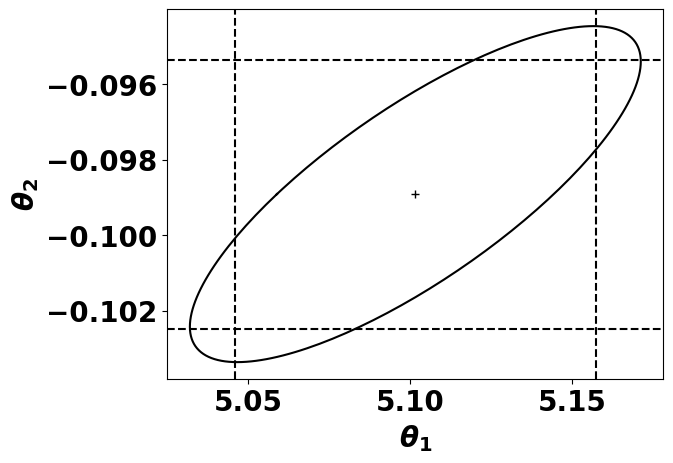

In [84]:
_,ax = plt.subplots()
ax.plot(thetapts[:,0], thetapts[:,1], color='black')
ax.plot(theta[0], theta[1], '+', color='black')
ax.axvline(x=marginal_t[0][0], linestyle='--', color='black')
ax.axvline(x=marginal_t[0][1], linestyle='--', color='black')
ax.axhline(y=marginal_t[1][0], linestyle='--', color='black')
ax.axhline(y=marginal_t[1][1], linestyle='--', color='black')

ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
plt.savefig("../figs/confidenceregionNL.png", bbox_inches="tight")

6.1 <= y_0 <= 6.2
6.1 <= y_1 <= 6.1
5.7 <= y_2 <= 5.8
5.6 <= y_3 <= 5.7
5.7 <= y_4 <= 5.8
5.7 <= y_5 <= 5.8
5.8 <= y_6 <= 5.9
6.0 <= y_7 <= 6.1
6.0 <= y_8 <= 6.1
5.6 <= y_9 <= 5.7
5.6 <= y_10 <= 5.6
5.6 <= y_11 <= 5.7
[1.92561337e+03 1.15017911e+00 3.45975884e-01 1.72749311e-01
 1.07375418e-01 7.74112910e-02 6.29785062e-02 5.62407110e-02
 5.34044278e-02 5.25146023e-02 5.25715376e-02 5.30715826e-02
 5.37622817e-02 5.45172572e-02]


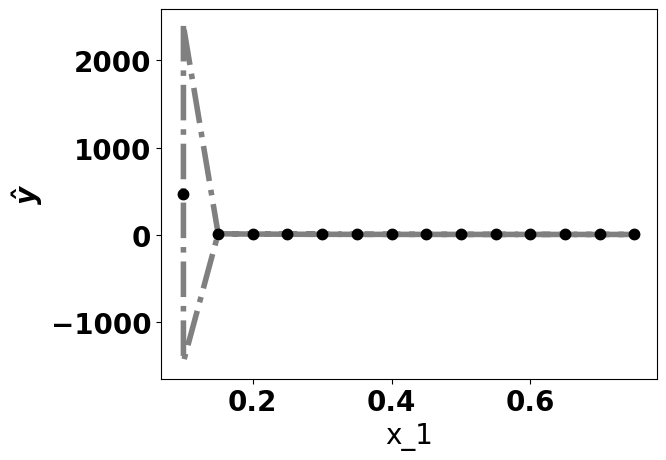

In [140]:
# Prediction Confidence Interval
j = J(x, theta)
for i, y_i in enumerate(f(x, theta).flatten()):    
    jr = (j[0,:] @ np.linalg.inv(r1))
    v = np.sqrt(s2 * (jr.T@jr))*np.abs(stats.t.ppf(1 - alpha/2, n-p))
    print(f"{y_i - v:0.2} <= y_{i} <= {y_i + v:0.2}")
    if i > 10:
        break

xi = np.arange(0.1, 0.8, 0.05)[:,np.newaxis]
j = J(xi, theta)

yy = np.linalg.norm(j @ np.linalg.inv(r1), axis=1) * np.sqrt(s2*p * stats.f.ppf(1-alpha, p, n-p))
y_h = f(xi, theta).flatten()

_,ax = plt.subplots()
ax.plot(xi[:,0], y_h, '.', color='black', markersize=15)
ax.fill_between(xi[:,0], y_h - yy, y_h + yy, edgecolor='gray', facecolor='white', alpha=1,
    linewidth=4, linestyle='dashdot', antialiased=True)
ax.set_xlabel('x_1')
ax.set_ylabel(r'$\hat{y}$')
plt.savefig('../figs/predbandML.png', bbox_inches="tight")

In [171]:
def f(x, theta):
    return np.exp(-theta[0]*x) + theta[1]*x/(theta[2] + x)
def J(x, theta):
    return np.hstack([-x*np.exp(-theta[0]*x), x/(theta[1]+x), -theta[0]*x/(theta[1]+x)**2])

theta2 = np.array([0.1, 0.1, 0.1])[:,np.newaxis]
theta2 = gauss(x, y, theta2, f, J)

-7.0635 <= theta2_0 <= 11.3979
-83.1215 <= theta2_1 <= 92.2864
-262.4584 <= theta2_2 <= 219.2662


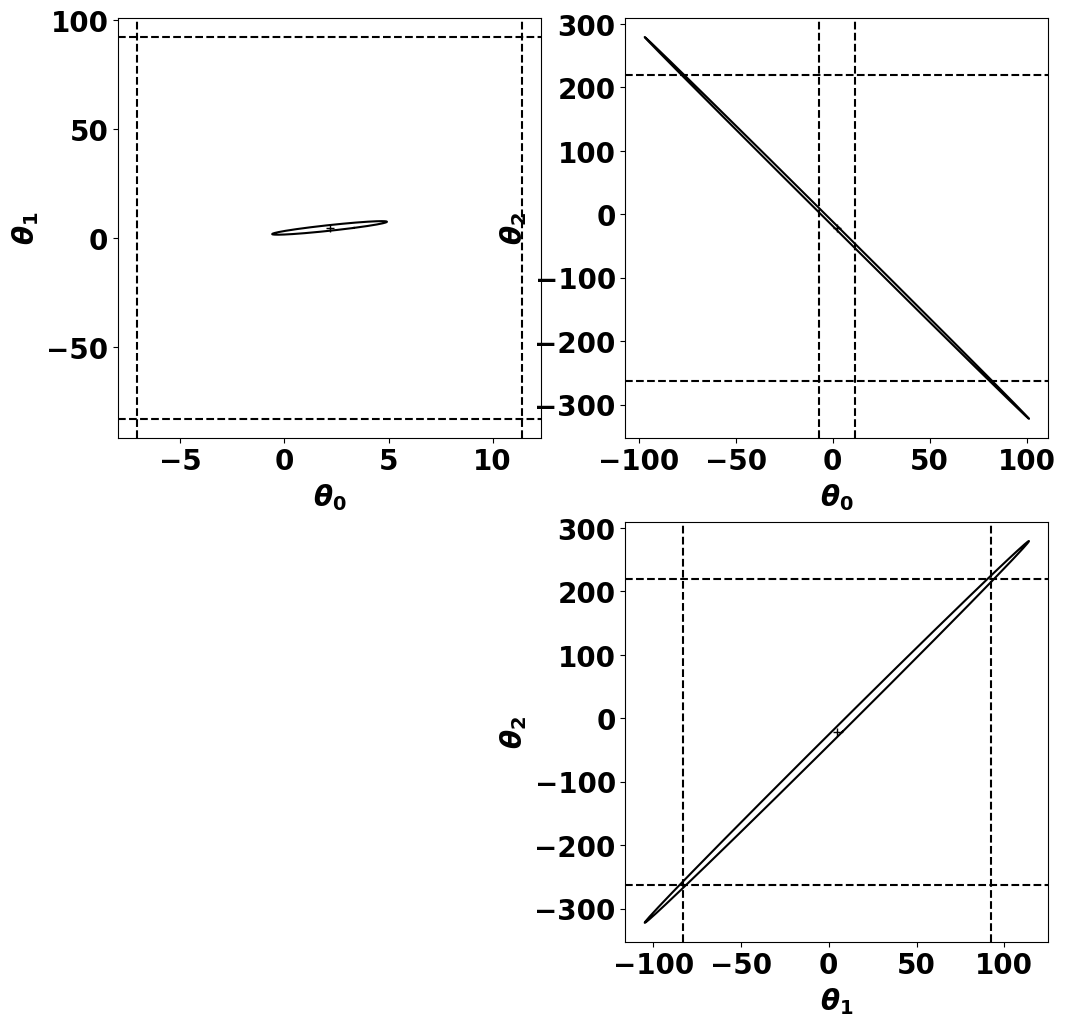

In [172]:
j = J(x, theta2)
s2 = np.sum((y - f(x,theta2))**2)/(n-p)
se = np.sqrt(s2 * np.diag(np.linalg.inv(j.T @ j)))

q, r = sc.linalg.qr(j)
q1 = q[:,:3]
r1 = r[:3, :3]

alpha = 0.05
marginal_t = []
for i, coef in enumerate(theta2.flatten()):
    v = np.abs(se[i]*stats.t.ppf(1 - alpha/2, n-p))
    marginal_t.append((coef - v, coef + v))
    print(f"{coef - v:0.4f} <= theta2_{i} <= {coef + v:0.4f}")

# joint interval
omegas = np.pi*np.arange(0, 2.01, 0.01)

_,axs = plt.subplots(2,2, figsize=(12,12))
for i in range(2):
    for j in range(i+1, 3):
        ixs = [i,j]
        const = np.sqrt(p*s2*stats.f.ppf(1-alpha, p, n-p))*np.linalg.inv(r1[[i,j], :][:,[i,j]])
        thetapts = np.array([theta2[ixs].flatten() + const @ np.array([np.cos(w), np.sin(w)]) for w in omegas])

        axs[i,j-1].plot(thetapts[:,0], thetapts[:,1], color='black')
        axs[i,j-1].plot(theta2[i], theta2[j], '+', color='black')
        axs[i,j-1].axvline(x=marginal_t[i][0], linestyle='--', color='black')
        axs[i,j-1].axvline(x=marginal_t[i][1], linestyle='--', color='black')
        axs[i,j-1].axhline(y=marginal_t[j][0], linestyle='--', color='black')
        axs[i,j-1].axhline(y=marginal_t[j][1], linestyle='--', color='black')
        
        axs[i,j-1].set_xlabel(r"$\theta_{i}$".format(i=i))
        axs[i,j-1].set_ylabel(r"$\theta_{j}$".format(j=j))
axs[1,0].axis('off')
plt.savefig("../figs/confidenceregionNLMulti.png", bbox_inches="tight")